In [1]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from rdkit.Chem import CanonSmiles

from mhfp.encoder import MHFPEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load model and training data

In [2]:
fingerprint_name = "mhfp6"
model_name = "rf"
model = torch.load(f"../models/combined/{fingerprint_name}_{model_name}.pkl")

# Load testing data - EU-OS Library

In [3]:
ecbl_df = pd.read_csv("../data/benchmark/ecbl_assay_results.csv")
biactive_df = pd.read_csv("../data/benchmark/bioactive_assay_results.csv")

In [4]:
ecbl_df.head(2)

,eos,smiles,Pseudomonas_aeruginosa_activity,Pseudomonas_aeruginosa_value,Candida_auris_activity,Candida_auris_value,Enterococcus_faecalis_activity,Enterococcus_faecalis_value,Escherichia_coli_activity,Escherichia_coli_value,Aspergillus_fumigatus_activity,Aspergillus_fumigatus_value,Candida_albicans_activity,Candida_albicans_value,Staphylococcus_aureus_activity,Staphylococcus_aureus_value
0,EOS3565,Cc1ccc(C)c(-c2n[nH]cc2CN2C[C@@H]3CC[C@H](C2)[C...,inactive,8.49,inactive,19.3,inactive,1.20,inactive,-15.53,inactive,6.7,inactive,-11.00,inactive,18.70
1,EOS4401,CCn1c(C)ccc(C(=O)N2CCCN(C(=O)c3ccoc3)CC2)c1=O,inactive,4.58,inactive,-10.8,inactive,-14.45,inactive,-9.56,inactive,7.5,inactive,-1.05,inactive,7.35


In [5]:
# Mapping the missing smiles
p = ecbl_df[["eos", "smiles"]].dropna().set_index("eos")["smiles"].to_dict()
k = {"EOS17062": "Cc1ccc(Cn2cnc3ccccc32)cc1", "EOS17004": "Cc1ccc(-n2sc3ccccc3c2=O)cc1"}

p.update(k)

ecbl_df["smiles"] = ecbl_df["eos"].map(p)

In [6]:
ecbl_df.shape, biactive_df.shape

((96092, 16), (4927, 16))

# Generate fingerprints

In [7]:
mhfp_encoder = MHFPEncoder(n_permutations=2048, seed=42)  # MHFP6 fingerprint

In [8]:
ecbl_mhfp6_fingerprints = []

for smiles in tqdm(ecbl_df["smiles"].values):
    # Generate the mol object
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        ecbl_mhfp6_fingerprints.append(None)
        continue

    ecbl_mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))

ecbl_df[fingerprint_name] = ecbl_mhfp6_fingerprints

100%|██████████| 96092/96092 [10:45<00:00, 148.92it/s]


In [9]:
bioactive_mhfp6_fingerprints = []

for smiles in tqdm(biactive_df["smiles"].values):
    # Generate the mol object
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        bioactive_mhfp6_fingerprints.append(None)
        continue

    bioactive_mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))

biactive_df[fingerprint_name] = bioactive_mhfp6_fingerprints

100%|██████████| 4927/4927 [00:35<00:00, 136.98it/s]


# Performing predictions

In [10]:
def get_predictions(df):
    predictions = model.predict(df[fingerprint_name].tolist())
    prediction_proba = model.predict_proba(df[fingerprint_name].tolist())
    label_classes = model.classes_.tolist()

    df["prediction"] = predictions

    probs = []

    for idx, probability in enumerate(prediction_proba):
        predicted_class = predictions[idx]
        probs.append(probability[label_classes.index(predicted_class)])

    df["probability"] = probs

    sns.set(style="whitegrid")
    df["probability"].plot(kind="hist", bins=100)
    plt.yscale("log")
    plt.xlabel("Probability")
    plt.title("Distribution of prediction probabilities")
    plt.show()
    return df

/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


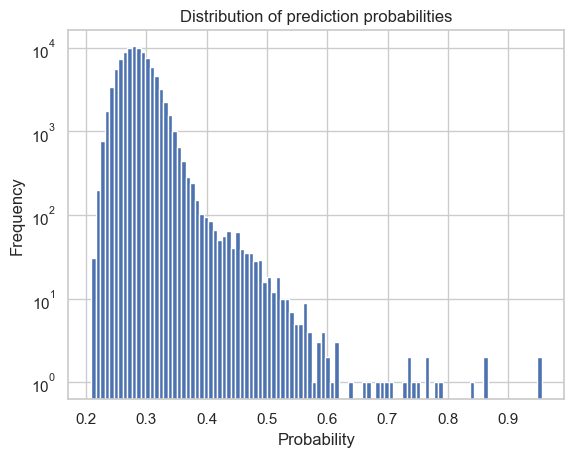

In [11]:
ecbl_df = get_predictions(ecbl_df)

/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/yojana/anaconda3/envs/amr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


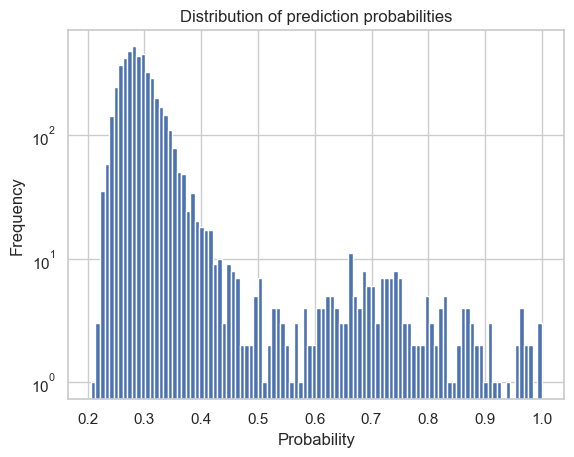

In [12]:
biactive_df = get_predictions(biactive_df)

# Similarity with training data

In [13]:
smote_training_df = pd.read_csv("../data/splits/combined/mhfp6_smote_train.csv")
smote_training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,11055388,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,15596084,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,inactive


In [14]:
smote_fingerprints = []

for row in tqdm(smote_training_df.values):
    cmpd_label = row[-1]
    cmpd_fingerprint = row[:-1]
    smote_fingerprints.append(cmpd_fingerprint)

100%|██████████| 105740/105740 [00:00<00:00, 2956349.94it/s]


In [17]:
from sklearn.metrics.pairwise import cosine_similarity


def get_sim_with_bioactive(train_fingerpint):
    cosine_df = cosine_similarity(bioactive_mhfp6_fingerprints, train_fingerpint)

    max_similarity_scores = []

    for sim_row in tqdm(cosine_df):
        max_similarity_scores.append(max(sim_row))

    # Distribution of similarity scores with training set
    sns.histplot(max_similarity_scores, bins=100)
    plt.yscale("log")
    plt.xlabel("Similarity score")
    plt.title("Distribution of similarity scores with training set")
    plt.show()

100%|██████████| 4927/4927 [00:11<00:00, 411.49it/s]


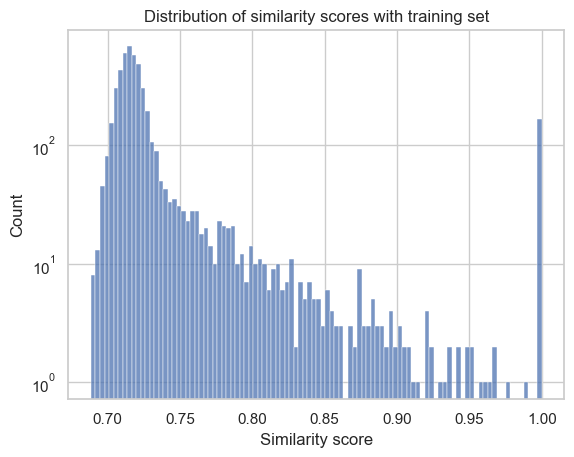

In [18]:
get_sim_with_bioactive(smote_fingerprints)

In [19]:
train_df = pd.read_csv("../data/splits/combined/mhfp6_train.csv")
train_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,cmp_id,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,OQZSOIHVULQZHS-CWGWECIMSA-N,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,ZGNROOOFYPKLJH-UHFFFAOYSA-N,inactive


In [20]:
train_fingerprints = []

for row in tqdm(train_df.values):
    cmpd_label = row[-1]
    cmpd_fingerprint = row[:-2]
    train_fingerprints.append(cmpd_fingerprint)

100%|██████████| 59361/59361 [00:00<00:00, 3139144.16it/s]


100%|██████████| 4927/4927 [00:06<00:00, 709.89it/s]


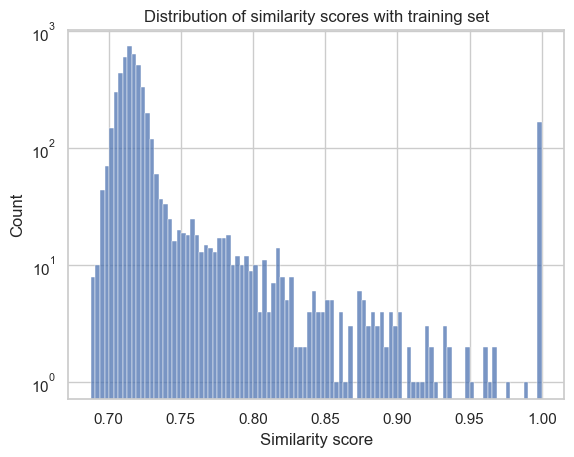

In [22]:
get_sim_with_bioactive(train_fingerprints)

# Saving the predictions

In [23]:
os.makedirs("../data/predictions", exist_ok=True)

In [24]:
ecbl_df.sort_values("probability", ascending=False, inplace=True)
ecbl_df.to_csv("../data/predictions/euos_ecbl_predictions.csv", index=False)

In [25]:
biactive_df.sort_values("probability", ascending=False, inplace=True)
biactive_df.to_csv("../data/predictions/euos_biactive_predictions.csv", index=False)